In [ ]:
# Edit these variables on your own

# directory that has your dataset
data_dirs = ['/content/gdrive/MyDrive/Dataset/DIV2K_train_HR/DIV2K_train_HR', 
             '/content/gdrive/MyDrive/Dataset/DIV2K_val_HR/DIV2K_val_HR']

n_layers = 17 # number of layers in neural network
n_epoch = 1000 # number of iteration for training the neural network
sigma = 25 # standard deviation of Gaussian noise
dncnn_path = 'mydenoiser.pth'

In [ ]:
# First we clone my repo that has all the wrapping functions for training a denoising network.
! git clone https://github.com/kristerseiya/Phase-Retrieval

In [ ]:
# navigate to the repo
% cd Phase-Retrieval

In [ ]:
# mount your google drive so that we can load the dataset you downloaded in your drive
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
# import modules
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from importlib import reload

from DnCNN import data
from DnCNN import model
from DnCNN import run
from DnCNN import utils

In [6]:
# Load the dataset to RAM
dataset = data.ImageDataset(data_dirs, store='ram', repeat=10)
trainset, valset, testset = dataset.split(0.7, 0.1, 0.2)

In [7]:
# this determines the size of a patch
# we do 50x50 for training set and validation set
# we don't take patches for testing set
trainset.set_patch(50)
trainset.set_mode('train')
valset.set_patch(50)
valset.set_mode('val')
testset.set_patch(-1)
testset.set_mode('test')

In [8]:
# create dataloader
trainldr = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
valldr = DataLoader(valset, batch_size=64, shuffle=False)
testldr = DataLoader(testset, batch_size=1, shuffle=False)

In [9]:
# we set our device to CUDA (GPU)
device = torch.device('cuda')

In [10]:
# we create a neural network and define optimizer
net = model.DnCNN(nb=n_layers, act_mode='BR').move(device)
optimizer = Adam(net.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, 200, gamma=0.1)

In [ ]:
# train a neural nework
log = run.train(net, optimizer, epoch, trainldr, sigma, validation=valldr, scheduler=scheduler)

In [ ]:
# test the neural network with testing data
test_mse = run.validate(net, testldr, sigma)
print('MSE: {:.5f}'.format(test_mse))

In [13]:
# This cell merges the batchnorm layers to convolutional layers 
# (it makes the inference faster)
utils.merge_bn(net)
net

In [15]:
# save the weights
torch.save(net.state_dict(), dncnn_path)

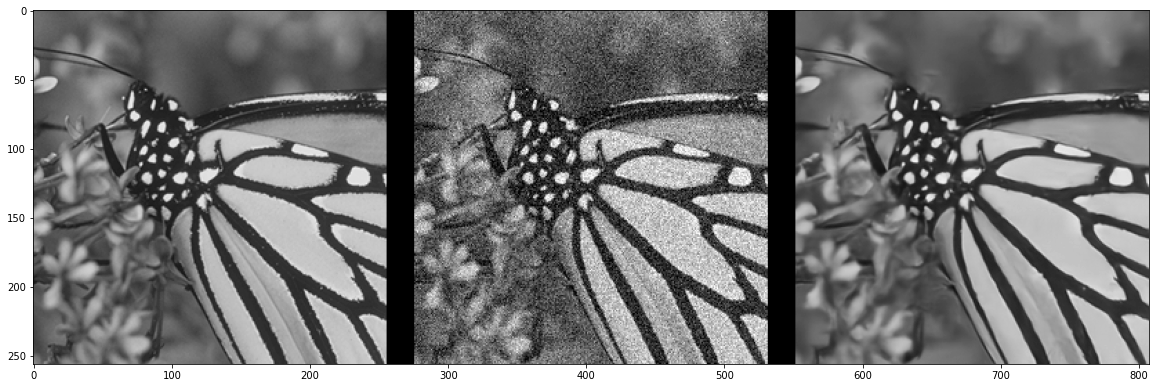

In [26]:
# Let's see how it actually performs

import tools
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('imgs/Monarch.tif').convert('L')
img = np.array(img) / 255.
noisy = img + np.random.normal(size=img.shape) * sigma / 255
x = torch.tensor(noisy, dtype=torch.float32, requires_grad=False, device=device)
x = x.view(1, 1, *x.size())
net = utils.load_dncnn(dncnn_path, device=device)
y = net(x)
y = y.cpu().squeeze(0).squeeze(0)
clean = y.numpy()
clean = np.clip(clean, 0, 1)

plt.figure(figsize=(20, 20))
tools.stackview([img, noisy, clean])